In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
TRAIN_DIR = '../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
TEST_DIR = '../input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'
IMG_SIZE = 192

datagen = ImageDataGenerator(rescale = 1./255,
                            validation_split = 0.2,
                            featurewise_center=False,  # set input mean to 0 over the dataset
                            samplewise_center=False,  # set each sample mean to 0
                            featurewise_std_normalization=False,  # divide inputs by std of the dataset
                            samplewise_std_normalization=False,  # divide each input by its std
                            zca_whitening=False,  # apply ZCA whitening
                            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
                            zoom_range = 0.1, # Randomly zoom image 
                            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                            horizontal_flip=True,  # randomly flip images
                            vertical_flip=False)  # randomly flip images)

In [3]:
train_data = datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    seed = 13,
    subset = 'training'
)
val_data = datagen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    seed = 13,
    subset = 'validation'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [4]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)
model = tf.keras.models.load_model('../input/kaggle-trained-upto10epochs/mobilenetv2_190_kaggle_bm142.h5')

In [5]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 29)                37149     
Total params: 2,295,133
Trainable params: 923,549
Non-trainable params: 1,371,584
_________________________________________________________________


In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [7]:
initial_epochs = 10
validation_steps=20
total_epochs = 17
loss0,accuracy0 = model.evaluate(val_data, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 7s 332ms/step - loss: 0.5198 - accuracy: 0.8984
initial loss: 0.52
initial accuracy: 0.90


In [8]:
history = model.fit(train_data,
                    epochs=total_epochs,
                    validation_data=val_data,
                    initial_epoch=initial_epochs,
                    callbacks=[learning_rate_reduction])

Epoch 11/17
2175/2175 [==============================] - 1024s 471ms/step - loss: 0.0175 - accuracy: 0.9951 - val_loss: 0.6658 - val_accuracy: 0.8868
Epoch 12/17
2175/2175 [==============================] - 885s 407ms/step - loss: 0.0143 - accuracy: 0.9958 - val_loss: 0.5514 - val_accuracy: 0.8953
Epoch 13/17
2175/2175 [==============================] - 892s 410ms/step - loss: 0.0153 - accuracy: 0.9956 - val_loss: 0.5859 - val_accuracy: 0.8929
Epoch 14/17
2175/2175 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9965
Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2175/2175 [==============================] - 908s 418ms/step - loss: 0.0115 - accuracy: 0.9965 - val_loss: 0.6857 - val_accuracy: 0.8893
Epoch 15/17
2175/2175 [==============================] - 893s 410ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.5052 - val_accuracy: 0.9020
Epoch 16/17
2175/2175 [==============================] - 871s 400ms/step - loss: 0.0045

In [9]:
model.save('mobilenetv2_192_kaggle_bm142.h5')

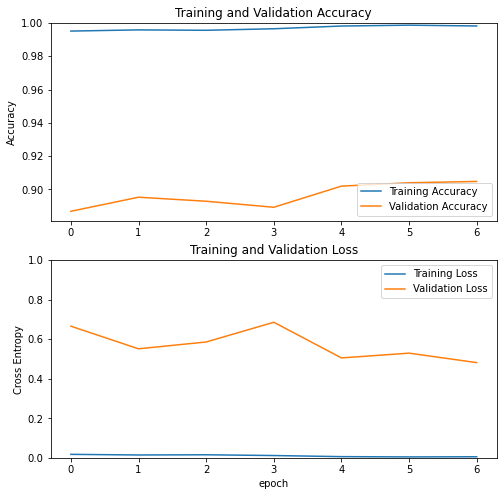

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('mobnet_kaggle_192.tflite', 'wb') as f:
    f.write(tflite_model)